In [1]:
#install some of the libraries
!pip install -q lxml sentence-transformers

#import other libraries
import os
import numpy as np
import pandas as pd
from lxml import etree #XML parser with namespace support (Claude puts the namespace in the <text> tag)
from sentence_transformers import SentenceTransformer, util #for computing embeddings and cosine similarity
import matplotlib.pyplot as plt
from google.colab import files

In [2]:
#clean up any existing XML files from previous sessions so that only the files uploaded in this run are considered
for f in os.listdir():
    if f.endswith('.xml'):
        os.remove(f)

#upload the files needed for the evaluation
print("Upload all XML files for this evaluation:")
uploaded = files.upload()

uploaded_filenames = []
for filename in uploaded:
    with open(filename, 'wb') as f: #w stands for write mode, b stands for binary mode
        f.write(uploaded[filename])
    uploaded_filenames.append(filename)

print("Files uploaded:", uploaded_filenames)

#choice of the gold standard
print("\nUploaded files:")
for i, fname in enumerate(uploaded_filenames):
    print(f"{i+1}. {fname}") #for each file in the list, prints it with a number starting from 1

idx = int(input("Enter the number corresponding to the gold standard file: ")) - 1 #subtracts 1 to get the correct index for the list
gold_file = uploaded_filenames[idx]
print(f"You have selected: {gold_file}")

Upload all XML files for this evaluation:


Saving AI_Manuscript_bufalini.xml to AI_Manuscript_bufalini.xml
Saving gold_manuscript_bufalini.xml to gold_manuscript_bufalini.xml
Files uploaded: ['AI_Manuscript_bufalini.xml', 'gold_manuscript_bufalini.xml']

Uploaded files:
1. AI_Manuscript_bufalini.xml
2. gold_manuscript_bufalini.xml
Enter the number corresponding to the gold standard file: 2
You have selected: gold_manuscript_bufalini.xml


In [3]:
#defining the AI model's files
model_files = [f for f in uploaded_filenames if f != gold_file]
MODEL_NAMES = [f.split('_')[0].capitalize() for f in model_files] #extracts and capitalizes just the model's names

In [4]:
#configuration of constants
#tags to extract
NOMINATIVE_TAGS = ['persName', 'placeName', 'date', 'title', 'orgName', 'opener', 'closer', 'signed', 'salute']
TEXTUAL_TAGS = ['text', 'body', 'div', 'p', 'l', 'lg', 'quote', 'q', 'cit', 'note', 'ab', 'ps']

#similarity threshold for semantic match (the cosine similarity must be of at least 0.85 to consider two embeddings a match)
SIMILARITY_THRESHOLD = 0.85

#weights for computing the hybrid final score, in which the nominative tags have a weight of 60% and the textual tags have a weight of 40%
WEIGHT_NOMINATIVE = 0.6
WEIGHT_TEXTUAL = 0.4

In [5]:
#load BERT model to perform embeddings
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
#normalization of strings needed for comparison
def normalize(text):
    return " ".join(text.strip().lower().split())

#function to parse xml and extract tag text
def extract_tags(filepath):
    try:
        tree = etree.parse(filepath)
    except Exception as e:
        print(f"Error parsing {filepath}: {e}") #if parsing fails, returns empty results with an error message
        return [], [] #in case of parsing error the code returns a list for nominative tags and one for textual tags, avoiding crashing the code

    #it takes the root element of the file to search for subelements using xpath
    root = tree.getroot()

    #check for namespaces
    ns = {}
    if root.tag.startswith("{"):
        uri = root.tag.split("}")[0].strip("{")
        ns = {'tei': uri} #namespace dictionary mapping tei to the URI extracted in the previous line
        def find_all(tag_list):
            return [normalize(el.text) for tag in tag_list for el in root.findall(f'.//tei:{tag}', namespaces=ns) if el.text and el.text.strip()]
    else:
        def find_all(tag_list):
            return [normalize(el.text) for tag in tag_list for el in root.iter(tag) if el.text and el.text.strip()]

    nominative = find_all(NOMINATIVE_TAGS)
    textual = find_all(TEXTUAL_TAGS)

    return nominative, textual

In [7]:
#nominative comparison (string matching)
def compare_nominative(gold, pred):
    gold_set = set(gold)
    pred_set = set(pred)
    #for exact string matching
    tp = len(gold_set & pred_set) #the length of the intersection between the two sets
    fp = len(pred_set - gold_set) #it gets the length of those elements that are not in the gold standard, so they were wrongly predicted
    fn = len(gold_set - pred_set) #it gets the elements that weren't predicted at all (so they are in the gold standard but not in the AI encoding)
    precision = tp / (tp + fp) if (tp + fp) else 0 #how much of the prediction was correct
    recall = tp / (tp + fn) if (tp + fn) else 0 #considering the gold standard, how much of it did the model get
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0 #harmonic meaning of the two above measures
    return precision, recall, f1

In [8]:
#textual comparison (semantic comparison)
def compare_textual(gold_segments, pred_segments):
    #if the lists are empty, precision, recall and f1 score are all 0
    if not gold_segments or not pred_segments:
        return 0, 0, 0
    #the segments are embedded into vectors (tensors)
    gold_emb = embedding_model.encode(gold_segments, convert_to_tensor=True)
    pred_emb = embedding_model.encode(pred_segments, convert_to_tensor=True)

    #track which gold segments have been matched
    tp = 0 #counts how many predicted segments correctly match a gold segment (true positives)
    matched_gold_indices = set()

    #calculating the cosine similarity, where cosine=0 means no similarity and cosine=1 means perfect match
    for seg in pred_emb:
        #this calculates the cosine similarity between the predicted segment (the model's output) and the gold segment
        scores = util.cos_sim(seg, gold_emb)[0].cpu().numpy() #seg is the single vector, gold_emb is the matrix of gold vectors
        best_idx = np.argmax(scores) #returns the index of the highest similarity (best_idx is the index of the most semantically similar gold segment to the current prediction)
        if scores[best_idx] >= SIMILARITY_THRESHOLD and best_idx not in matched_gold_indices:
            tp += 1
            matched_gold_indices.add(best_idx)

    #calculating the quantitative measures
    fp = len(pred_segments) - tp #predicted segments that didn't match any gold segment
    fn = len(gold_segments) - tp #gold segments that weren’t matched by any prediction segment
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return precision, recall, f1

In [9]:
#main evaluation function
def evaluate_models():
    gold_nominative, gold_textual = extract_tags(gold_file)

    print("Gold standard sample tags:")
    print("Nominative (first 5):", gold_nominative[:5])
    print("Textual (first 2):", gold_textual[:2])

    #empty list to collect performance metrics for each model
    results = []
    for model_path in model_files:
        model_name = model_path.split('_')[0].capitalize()
        pred_nominative, pred_textual = extract_tags(model_path)

        print(f"Evaluating model: {model_name}")
        print("Nominative extracted:", pred_nominative[:5])
        print("Textual extracted:", pred_textual[:2])

        p_nom, r_nom, f1_nom = compare_nominative(gold_nominative, pred_nominative)
        p_txt, r_txt, f1_txt = compare_textual(gold_textual, pred_textual)
        #combines the F1 score for exact tags and the F1 score for semantic tags using a weighted average
        final_score = WEIGHT_NOMINATIVE * f1_nom + WEIGHT_TEXTUAL * f1_txt

        #dictionary with all the performance metrics for one model that is appended to the results list
        results.append({
            "Model": model_name,
            "Precision (Nominative)": round(p_nom, 3),
            "Recall (Nominative)": round(r_nom, 3),
            "F1 (Nominative)": round(f1_nom, 3),
            "Precision (Textual)": round(p_txt, 3),
            "Recall (Textual)": round(r_txt, 3),
            "F1 (Textual)": round(f1_txt, 3),
            "Final Hybrid Score": round(final_score, 3)
        }) #everything is rounded to 3 decimal places for cleaner output in the CSV and plots

    return pd.DataFrame(results)

In [10]:
#final report
df_results = evaluate_models()

df_results.to_csv("tei_comparison_report.csv", index=False)
print("CSV saved locally as 'tei_comparison_report.csv'")

from google.colab import drive
drive.mount('/content/drive')
drive_path = "/content/drive/MyDrive/tei_comparison_report.csv"
df_results.to_csv(drive_path, index=False)
print(f"CSV also saved to your Google Drive: {drive_path}")

Gold standard sample tags:
Nominative (first 5): ['cristo', 'dio', 'cristo', 'dio', '1822']
Textual (first 2): ["source text for masters' thesis research", 'madre dei santi, immagine']
Evaluating model: Ai
Nominative extracted: ['hegel', 'marx', 'cristo', 'la pentecoste']
Textual extracted: ['encoded for demonstration purposes.', 'source of the text not specified.']
CSV saved locally as 'tei_comparison_report.csv'
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV also saved to your Google Drive: /content/drive/MyDrive/tei_comparison_report.csv


,Model,Precision (Nominative),Recall (Nominative),F1 (Nominative),Precision (Textual),Recall (Textual),F1 (Textual),Final Hybrid Score
0,Ai,0.5,0.333,0.4,0.733,0.957,0.83,0.572


<Figure size 640x480 with 0 Axes>

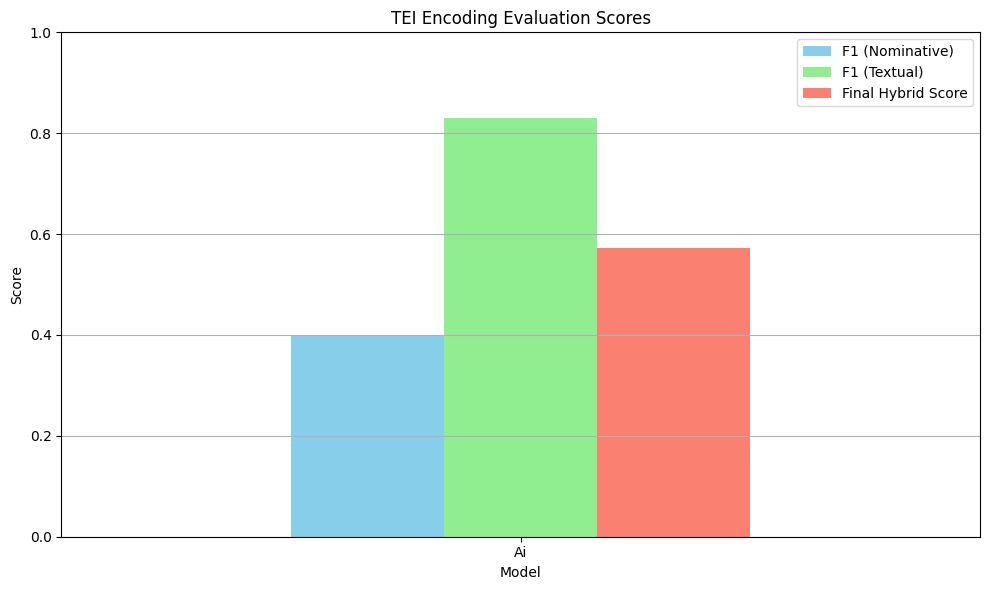

In [11]:
#visualization of results
#grouped bar chart wher each bar of each group (a model) represents a measure's score
display(df_results)

plt.clf()
ax = df_results.set_index("Model")[["F1 (Nominative)", "F1 (Textual)", "Final Hybrid Score"]].plot.bar(
    figsize=(10, 6), rot=0, color=["skyblue", "lightgreen", "salmon"]
)
plt.title("TEI Encoding Evaluation Scores")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()